In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from coffea import hist
from coffea.processor import defaultdict_accumulator

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)
#hep.CMS.text("Phase 2 Simulation")

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

2023-06-28 05:06:47.810216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 05:06:47.985703: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 05:06:47.991555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/s

In [2]:
model_id_name = '../../models/Feb_4_2023_JetMetTalk_v1_SigPtTruth20.h5'
model_pt_regress_name = '../models/pt_regress_v1.h5'

In [3]:
test_index = 400000

In [4]:
MinBias = uproot4.open("../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root")
MinBias_id = np.asarray(MinBias['ntuplePupSingle']['tree']['event'].array())[test_index:]
MinBias_iso = np.asarray(MinBias['ntuplePupSingle']['tree']['chargedIso'].array())[test_index:]
MinBias_pt = np.asarray(MinBias['ntuplePupSingle']['tree']['pt'].array())[test_index:]
MinBias_inputs = np.nan_to_num(np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array())[test_index:])

n_event = np.unique(MinBias_id).shape[0]

In [5]:
model_id = load_model(model_id_name)
MinBias_nn_score_model = model_id.predict(MinBias_inputs)

model_regress = load_model(model_pt_regress_name)
MinBias_nn_selected_pt_ratio = model_regress.predict(MinBias_inputs).flatten()

2023-06-28 05:06:58.195338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/e906/app/software/osg/software/e1039/share-20210115/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/root/lib
2023-06-28 05:06:58.195365: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-28 05:06:58.195385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (submit05.mit.edu): /proc/driver/nvidia/version does not exist
2023-06-

8869/8869 [==============================] - 5s 582us/step


In [6]:
MinBias_pt_corrected = np.multiply(MinBias_nn_selected_pt_ratio, MinBias_pt)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


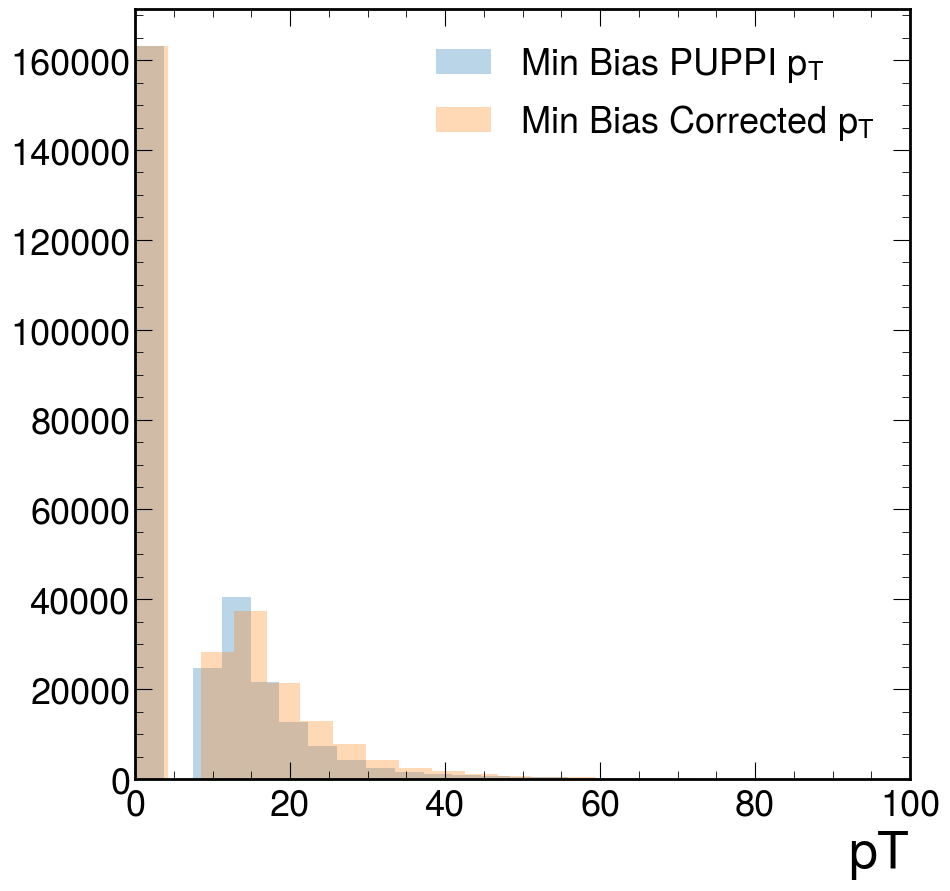

In [7]:
plt.hist(MinBias_pt, bins = 100, alpha=0.3, label=r'Min Bias PUPPI $p_T$')
plt.hist(MinBias_pt_corrected, bins =100, alpha=0.3, label=r'Min Bias Corrected $p_T$')
plt.xlim([0,100])
plt.xlabel(r'$pT$')
plt.legend()

In [8]:
nn_cut = 0.28  #official NN cut point

In [9]:
MinBias_nn_selected_id = MinBias_id[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt = MinBias_pt[MinBias_nn_score_model.flatten() > nn_cut]
MinBias_nn_selected_pt_corrected = MinBias_pt_corrected[MinBias_nn_score_model.flatten() > nn_cut]

In [10]:
minbias_rate_nn = []
minbias_rate_nn_corrected = []

pt_cuts = list(np.arange(0,250,10))

for pt_cut in pt_cuts:
    
    print("pT Cut: ", pt_cut)
    n_pass_nn = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt > pt_cut]).shape[0]
    n_pass_nn_corrected = np.unique(MinBias_nn_selected_id[MinBias_nn_selected_pt_corrected > pt_cut]).shape[0]
    print("Ratio (NN): ", n_pass_nn/n_event)
    print('------------')
    
    minbias_rate_nn.append((n_pass_nn/n_event)*32e+3) #Convert to kHz (multiply by 32e+3)
    minbias_rate_nn_corrected.append((n_pass_nn_corrected/n_event)*32e+3)


pT Cut:  0
Ratio (NN):  0.27470276159348206
------------
pT Cut:  10
Ratio (NN):  0.2584197811567429
------------
pT Cut:  20
Ratio (NN):  0.04423049594997868
------------
pT Cut:  30
Ratio (NN):  0.014546129190153632
------------
pT Cut:  40
Ratio (NN):  0.006240822320117474
------------
pT Cut:  50
Ratio (NN):  0.002996068400360002
------------
pT Cut:  60
Ratio (NN):  0.0016302717382723068
------------
pT Cut:  70
Ratio (NN):  0.0008368465097184722
------------
pT Cut:  80
Ratio (NN):  0.0004697393144174443
------------
pT Cut:  90
Ratio (NN):  0.0003118437465460344
------------
pT Cut:  100
Ratio (NN):  0.00017368512465855084
------------
pT Cut:  110
Ratio (NN):  0.00010657950831320165
------------
pT Cut:  120
Ratio (NN):  6.315822714856394e-05
------------
pT Cut:  130
Ratio (NN):  3.9473891967852463e-05
------------
pT Cut:  140
Ratio (NN):  3.5526502771067216e-05
------------
pT Cut:  150
Ratio (NN):  2.7631724377496724e-05
------------
pT Cut:  160
Ratio (NN):  1.973694598392

In [11]:
# For plotting sifnal eff
# plt.plot(pt_cuts, minbias_rate_nn, label = r"NN ID (No $p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
# plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID ($p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)

# hep.cms.text("Phase 2 Simulation")
# hep.cms.lumitext("PU 200 (14 TeV)")
# #plt.yscale('log')
# plt.ylabel(r"Signal efficiency")
# plt.xlabel(r"$p_T$ Cut [GeV]")
# plt.legend(loc = 'lower left',fontsize = 15)
# plt.show()

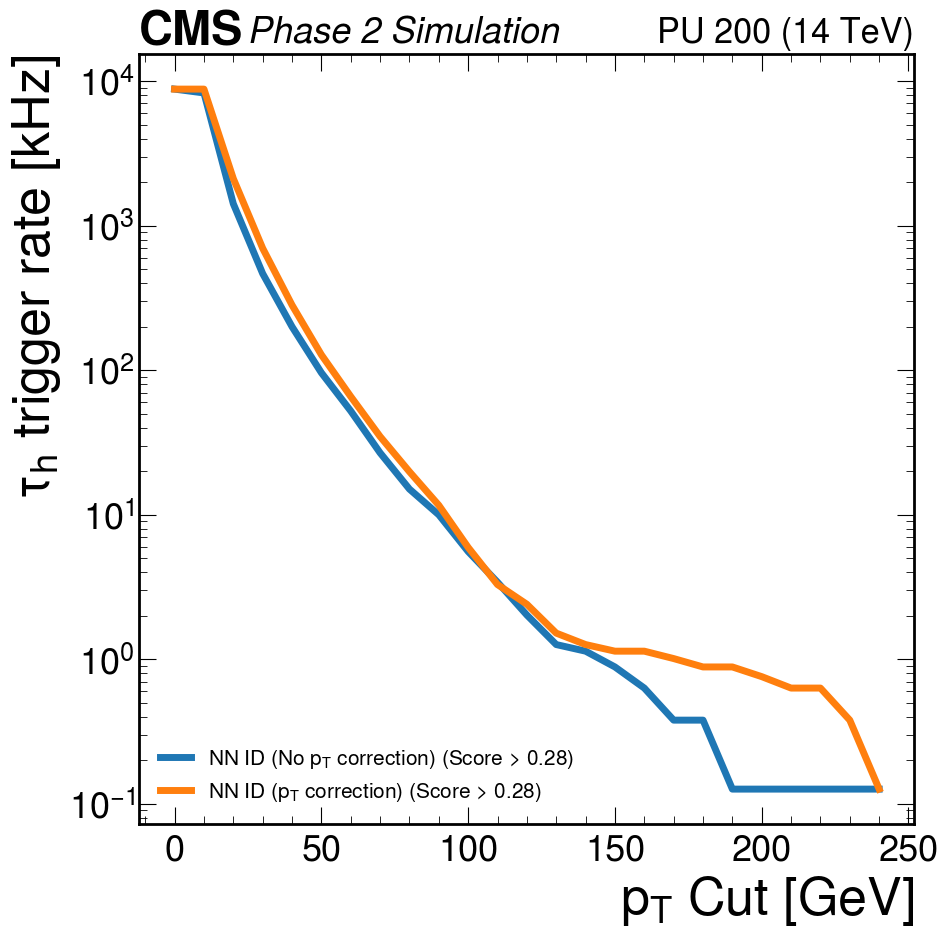

In [12]:
plt.plot(pt_cuts, minbias_rate_nn, label = r"NN ID (No $p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)
plt.plot(pt_cuts, minbias_rate_nn_corrected, label = r"NN ID ($p_T$ correction) (Score > {})".format(nn_cut), linewidth=5)

hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.yscale('log')
plt.ylabel(r"$\tau_h$ trigger rate [kHz]")
plt.xlabel(r"$p_T$ Cut [GeV]")
plt.legend(loc = 'lower left',fontsize = 15)
plt.show()

-----

# Re-plotting the ROC curve

In [13]:
def prep_rate_data(ModelNameID,
             ModelNameRegress,
             truth_sig_pt_cut=50,
             minbias_pt_cut_value=50,
             minbias_path = "../../ntuples/Jan_25_2023/test_bkg_v12_emseed.root",
             sig_path = "../../ntuples/Jan_25_2023/test_sig_v12_emseed.root",
             TreeName='ntuplePupSingle',
             test_index=400000):
    
    
    modelID = load_model(ModelNameID)
    
    #Load the data
    MinBias = uproot4.open(minbias_path)
    sig = uproot4.open(sig_path)
    
    #Signal data prep
    truth_pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    truth_deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    truth_eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection_sig = (truth_pt_sig > truth_sig_pt_cut) & (abs(truth_deltaR_sig) < 0.4) &(abs(truth_eta_sig) < 2.4)

    sig_id = np.asarray(sig['ntuplePupSingle']['tree']['event'].array()[test_index:][selection_sig])
    sig_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[test_index:][selection_sig])
    sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][selection_sig])      
    
    #Pick out unique events
    minbias_id, minbias_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()[test_index:]), return_index=True)
    sig_id_temp, sig_index_temp = np.unique(sig_id, return_index=True)
    
    true_sig_id, _, true_signal_index = np.intersect1d(np.unique(minbias_id), np.unique(sig_id_temp), return_indices=True)
    
    #True signal data preparation (these are events that actually overlaps with MinBias)
    true_sig_pt = sig_pt[sig_index_temp][true_signal_index]
    true_sig_input = sig_input[sig_index_temp][true_signal_index]
    true_sig_score = modelID.predict(true_sig_input).flatten()
    
    minbias_pt = MinBias['ntuplePupSingle']['tree']['pt'].array()[test_index:][minbias_index]
    minbias_input = np.asarray(MinBias['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:][minbias_index])
    minbias_input[abs(minbias_input) > 1e+9] = 0.

    minbias_score = modelID.predict(minbias_input).flatten()
    
    #
    sig_pt_cut = true_sig_pt > minbias_pt_cut_value
    minbias_pt_cut = minbias_pt > minbias_pt_cut_value
    
    true_sig_score_pt = true_sig_score[sig_pt_cut]
    minbias_score_pt = minbias_score[minbias_pt_cut]
    
    #Now apply correction
    model_regress = load_model(ModelNameRegress)
    
    minbias_pt_corrected_ratio = model_regress.predict(minbias_input).flatten()
    minbias_pt_corrected = np.multiply(minbias_pt, minbias_pt_corrected_ratio)

    true_sig_pt_corrected_ratio = model_regress.predict(true_sig_input).flatten()
    true_sig_pt_corrected = np.multiply(true_sig_pt, true_sig_pt_corrected_ratio)
    
    sig_pt_cut_corrected = true_sig_pt_corrected > minbias_pt_cut_value
    minbias_pt_cut_corrected = minbias_pt_corrected > minbias_pt_cut_value
    
    true_sig_score_pt_corrected = true_sig_score[sig_pt_cut_corrected]
    minbias_score_pt_corrected = minbias_score[minbias_pt_cut_corrected]
    
    n_event = minbias_index.shape[0]
    n_sig_event = true_sig_id.shape[0]
    
    ##LOOP to calculate the ROC curves
    tau_score_edges = [round(i,2) for i in np.arange(0, 0.8, 0.01).tolist()]+\
                  [round(i,4) for i in np.arange(0.9, 1, 0.0001)] + [1]

    sig_list = []
    bkg_list = []

    for tau_score_cut in tau_score_edges:
    
        bkg_pass = sum(minbias_score_pt>tau_score_cut)
        sig_pass = sum(true_sig_score_pt>tau_score_cut)
        
        sig_list.append(sig_pass/n_sig_event)
        bkg_list.append(bkg_pass/n_event)

    
    bkg_list_scaled = [i*(32e+3) for i in bkg_list]
    
    sig_list_corrected = []
    bkg_list_corrected = []

    for tau_score_cut in tau_score_edges:
        bkg_pass = sum(minbias_score_pt_corrected>tau_score_cut)
        sig_pass = sum(true_sig_score_pt_corrected>tau_score_cut)

        sig_list_corrected.append(sig_pass/n_sig_event)
        bkg_list_corrected.append(bkg_pass/n_event)

    bkg_list_scaled_corrected = [i*(32e+3) for i in bkg_list_corrected]
    
    
    plt.plot([],[], 'none', label=r'(MinBias $p_T^{reco (or~corrected)}$ >  % d GeV)'%int(minbias_pt_cut_value))
    plt.plot(sig_list, bkg_list_scaled, label=r'Tau NN ID (No $p_T$ Correction)',linewidth=5)
    plt.plot(sig_list_corrected, bkg_list_scaled_corrected, label=r'Tau NN ID ($p_T$ Correction)',linewidth=5)
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")

    plt.ylabel(r'$Single \tau_h$ Trigger Rate [kHz]')
    plt.xlabel(r'$\tau_h$ [$p_T^{gen} > % d$ GeV]' %int(truth_sig_pt_cut))

    plt.yscale('log')
    #plt.ylim([10e-2,10e+4])
    plt.legend(loc='best',fontsize=20)
    plt.show()
    
    return n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected


115/115 [==============================] - 0s 548us/step


115/115 [==============================] - 0s 557us/step


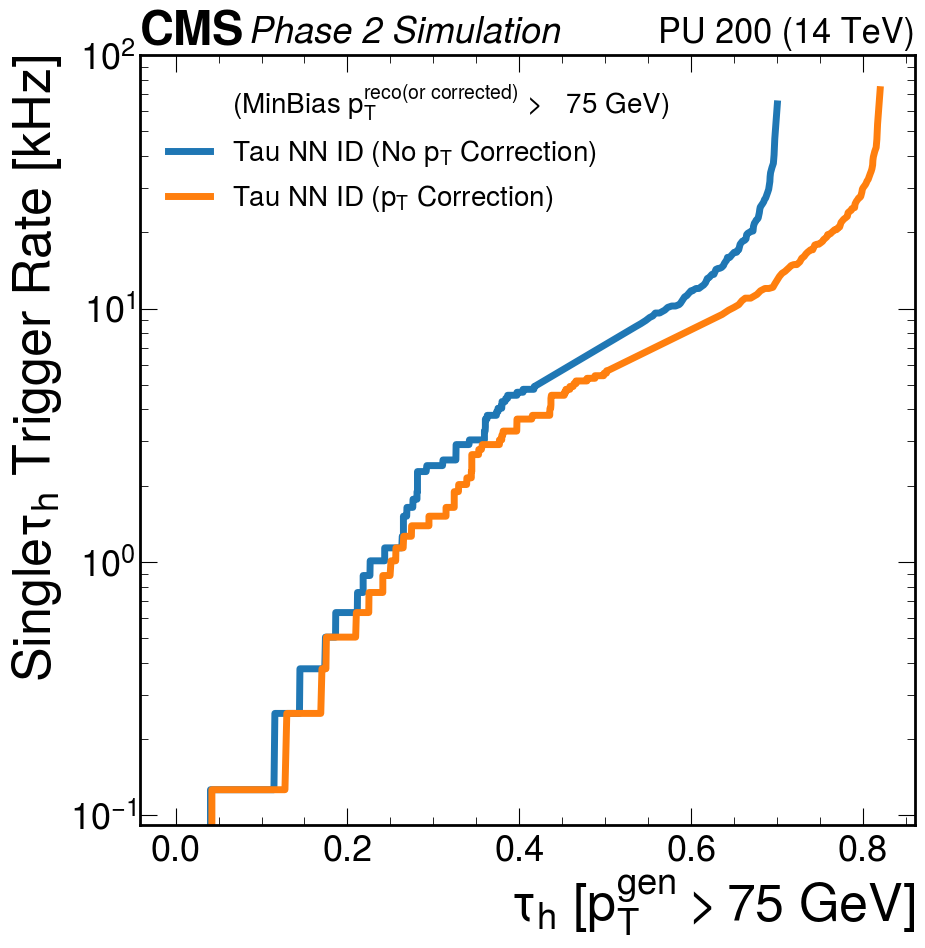

In [14]:
n_event, n_sig_event, true_sig_score_pt, minbias_score_pt, true_sig_score_pt_corrected, minbias_score_pt_corrected = prep_rate_data(model_id_name,
                                                                                                                                    '../models/pt_regress_v1.h5',
                                                                                                                                    truth_sig_pt_cut=75,
                                                                                                                                    minbias_pt_cut_value=75)